In [73]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
import matplotlib.mlab as mlab
# display plots in this notebook
%matplotlib inline

# set display defaults
plt.rcParams['figure.figsize'] = (10, 10)        # large images
plt.rcParams['image.interpolation'] = 'nearest'  # don't interpolate: show square pixels
plt.rcParams['image.cmap'] = 'gray'  # use grayscale output rather than a (potentially misleading) color heatmap

#from dataloader import *
import os.path
import math
import cv2.cv as cv
import sys

In [74]:
RADIUS = 0.02
MASS = 0.00275
GRAVITY = 9.82
RHO_A = 1.29
C_D = 0.405
C_M = 0.62
PI = 3.141592653
dT = 0.005
kD = 0.5*MASS*C_D*RHO_A*PI*RADIUS*RADIUS*dT
kM = 0.5*MASS*C_M*RHO_A*RADIUS*PI*RADIUS*RADIUS*dT

In [141]:
kalman = cv.CreateKalman(6, 3, 1)
process_noise = cv.CreateMat(6, 1, cv.CV_32FC1)
measurement = cv.CreateMat(3, 1, cv.CV_32FC1)
control = cv.CreateMat(1, 1, cv.CV_32FC1)
rng = cv.RNG(-1)

cv.Zero(measurement)

In [178]:
def init_kalman(kalman,x,y,z):
    
    kalman.transition_matrix[:,:] = 0
    for i in range(6):
        kalman.transition_matrix[i,i] = 1
    kalman.transition_matrix[0,3] = dT
    kalman.transition_matrix[1,4] = dT
    kalman.transition_matrix[2,5] = dT

    kalman.state_post[:,:] = 0

    kalman.control_matrix[:,:] = 0
    kalman.control_matrix[5,0] = 1

    cv.SetIdentity(kalman.measurement_matrix, cv.RealScalar(1))
    cv.SetIdentity(kalman.process_noise_cov, cv.RealScalar(1e-5))
    cv.SetIdentity(kalman.measurement_noise_cov, cv.RealScalar(1e-5))
    cv.SetIdentity(kalman.error_cov_post, cv.RealScalar(1))
    
    kalman.state_post[0,0]=x
    kalman.state_post[1,0]=y
    kalman.state_post[2,0]=z

def track(kalman,x,y,z):
    vx = kalman.state_post[3,0]
    vy = kalman.state_post[4,0]
    vz = kalman.state_post[5,0]
    v = math.sqrt(vx**2+vy**2+vz**2)
    kalman.transition_matrix[3,3] = 1-kD*v
    kalman.transition_matrix[4,4] = 1-kD*v
    kalman.transition_matrix[5,5] = 1-kD*v
    control[0,0] = -GRAVITY*dT
    cv.KalmanPredict(kalman, control)
    pred = [kalman.state_pre[0,0],kalman.state_pre[1,0],kalman.state_pre[2,0]]
    
    cv.RandArr(rng, measurement, cv.CV_RAND_NORMAL, cv.RealScalar(0),cv.RealScalar(0.001))
    measurement[0,0] += x
    measurement[1,0] += y
    measurement[2,0] += z
    cv.KalmanCorrect(kalman, measurement)
    
    meas = [measurement[0,0],measurement[1,0],measurement[2,0]]
    
    return pred, meas, np.array([x,y,z])

def sample(kalman):
    vx = kalman.state_post[3,0]
    vy = kalman.state_post[4,0]
    vz = kalman.state_post[5,0]
    v = math.sqrt(vx**2+vy**2+vz**2)
    kalman.transition_matrix[3,3] = 1-kD*v
    kalman.transition_matrix[4,4] = 1-kD*v
    kalman.transition_matrix[5,5] = 1-kD*v
    control[0,0] = -GRAVITY*dT
    cv.KalmanPredict(kalman, control)
    pred = [kalman.state_pre[0,0],kalman.state_pre[1,0],kalman.state_pre[2,0]]
    return pred

In [179]:
init = False
preds = []
meass = []
reals = []
coords = open('in.txt','r')
for line in coords.readlines():
    coord = map(float, line.strip().split(' '))
    if not init:
        init_kalman(kalman, coord[0]/1000, coord[1]/1000, coord[2]/1000)
        init = True
    else:
        pred, meas, real = track(kalman, coord[0]/1000, coord[1]/1000, coord[2]/1000)
        preds.append(pred)
        meass.append(meas)
        reals.append(real)
preds = np.array(preds)
meass = np.array(meass)
reals = np.array(reals)
print preds.shape

(124, 3)


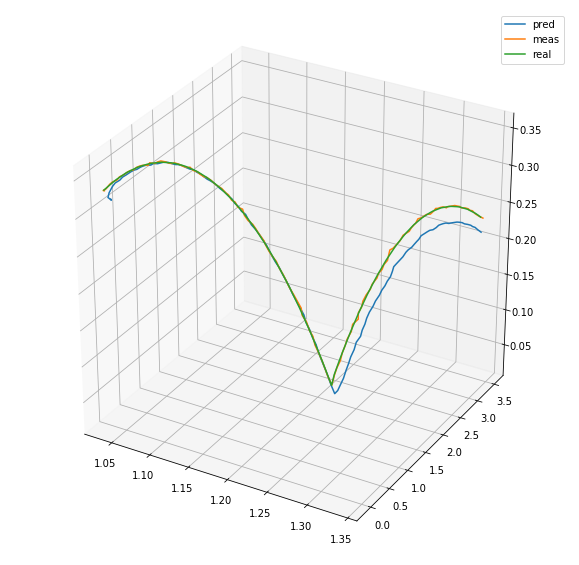

In [180]:
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot(preds[:,0],preds[:,1],preds[:,2],label='pred')
ax.plot(meass[:,0],meass[:,1],meass[:,2],label='meas')
ax.plot(reals[:,0],reals[:,1],reals[:,2],label='real')
ax.legend(loc='best')

max z is 458
31998 train samples and 8000 test samples


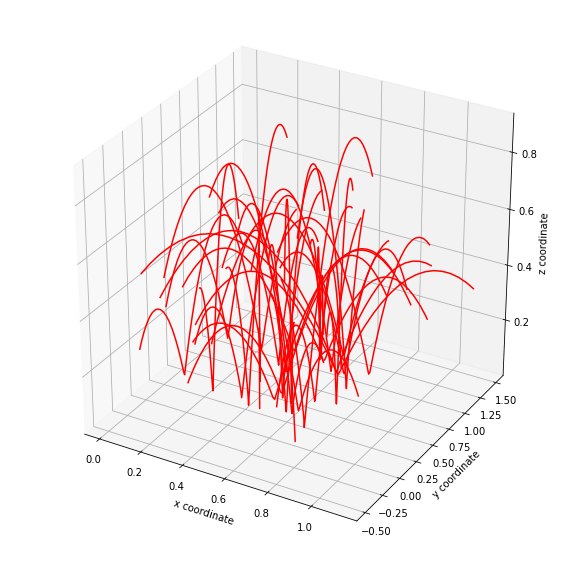

In [148]:
from dataloader import *
directory = 'data/'
filename = 'coords.csv'
config = {}
config['seq_len'] = 120
config['batch_size'] = 20
config['overlap_rate'] = 0.0
config['coords'] = 3
config['mixtures'] = 2

dl = DataLoad(directory, filename)
dl.load_data(config['seq_len'], config['overlap_rate'], augment = True, verbose = False)
dl.split_train_test(0.8)

data = dl.data
X_test = np.transpose(data['X_test'], [0,2,1])
X_test_raw = np.transpose(data['X_test_raw'], [0,2,1])

fig = plt.figure()
ax = fig.gca(projection='3d')
for i in range(30):
    seq = X_test_raw[i]
    ax.plot(seq[0,:], seq[1,:], seq[2,:],'r')
ax.set_xlabel('x coordinate')
ax.set_ylabel('y coordinate')
ax.set_zlabel('z coordinate')
plt.show()

In [192]:
def sample_more(X, sl_pre, sample_until_landing=False):
    #[3,seq_len]
    init = False
    preds = []
    meass = []
    reals = []
    for i in range(X.shape[1]):
        coord = X[:,i]
        if not init:
            init_kalman(kalman, coord[0]*1.525, coord[1]*2.74, coord[2]*0.458)
            init = True
        elif i<sl_pre:
            pred, meas, real = track(kalman, coord[0]*1.525, coord[1]*2.74, coord[2]*0.458)
            preds.append(pred)
            meass.append(meas)
            reals.append(real)
        else:
            pred = sample(kalman)
            preds.append(pred)
            if sample_until_landing and pred[2]<RADIUS:
                break
    preds = np.array(preds)
    meass = np.array(meass)
    reals = np.array(reals)
    return preds

In [211]:
kalman = cv.CreateKalman(6, 3, 1)
preds = sample_more(X_test_raw[0], 4, True)
preds[:,0] = preds[:,0] / 1.525
preds[:,1] = preds[:,1] / 2.74
preds[:,2] = preds[:,2] / 0.458

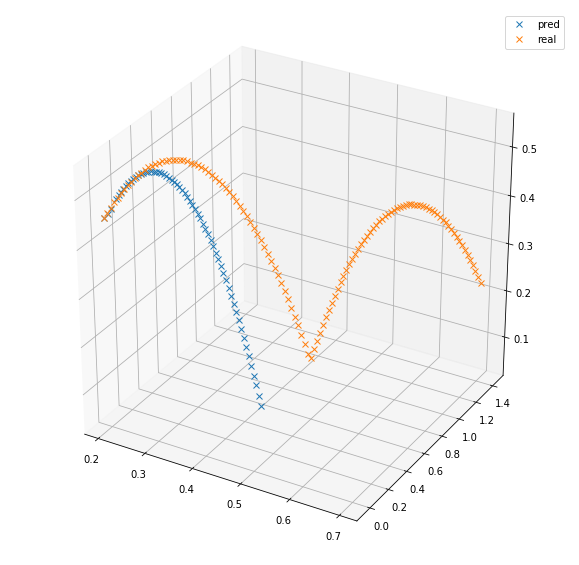

In [212]:
X = X_test_raw[0]

fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot(preds[:,0],preds[:,1],preds[:,2],'x',label='pred')
ax.plot(X[0,:],X[1,:],X[2,:],'x',label='real')
ax.legend(loc='best')

In [213]:
def find_landing_point(seq):
    #[3,seq_len]
    for i in range(1,seq.shape[1]-1):
        if seq[2,i+1]>seq[2,i] and seq[2,i-1]>seq[2,i]:
            return i, seq[:,i]
    return None

def find_landing_point_for_kalman(seq):
    #[3,seq_len]
    for i in range(seq.shape[0]):
        if seq[i,2]<0:
            return i, seq[i,:]
    return None

In [214]:
idx,pt_real = find_landing_point(X_test_raw[0])

In [215]:
def distance(pt1, pt2):
    return math.sqrt((pt1[0]-pt2[0])**2+(pt1[1]-pt2[1])**2)

def distance_3d(pt1, pt2):
    return math.sqrt((pt1[0]-pt2[0])**2+(pt1[1]-pt2[1])**2+(pt1[2]-pt2[2])**2)

def to_world(pt):
    return [pt[0]*1525, pt[1]*2740, pt[2]*458]

In [216]:
distance(to_world(pt_real), to_world(preds[idx]))

589.5399525874133

### Landing point prediction

0 / 2000


/home/jing/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:14: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


500 / 2000
1000 / 2000
1500 / 2000
17.9258969226


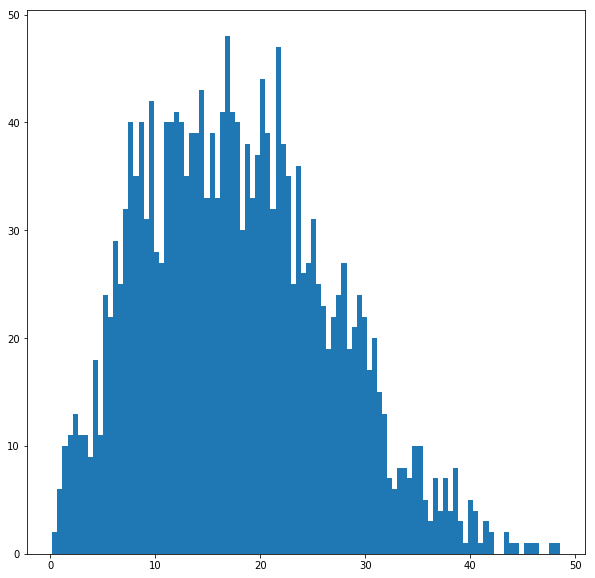

In [225]:
N = X_test.shape[0]/4
dist = 0
dists = []
valid = 0
for i in range(N):
    if i%500==0:
        print i,'/',N
    kalman = cv.CreateKalman(6, 3, 1)
    preds = sample_more(X_test[i], 30, False)
    preds[:,0] = preds[:,0] / 1.525
    preds[:,1] = preds[:,1] / 2.74
    preds[:,2] = preds[:,2] / 0.458
    idx, pt2 = find_landing_point(X_test_raw[i])
    if pt2 == None:
        continue
    d = distance(to_world(preds[idx]), to_world(pt2))
    #if d>100:
    #    print i, d
    dist += d
    dists.append(d)
    valid += 1
print dist/valid
_ = plt.hist(dists, bins=100)